# Libraries

In [1]:
# to create a spark session object
from pyspark.sql import SparkSession

# data types
from pyspark.sql.types import *

# DBMS: Read and Write

## MongoDB

In [2]:
# Session with Mongo
spark_mongo = SparkSession \
    .builder \
    .appName("last_dance_mongo") \
    .config("spark.mongodb.input.uri", "mongodb://127.0.0.1/amazon.music") \
    .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/amazon.msample") \
    .config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.11:2.4.1') \
    .getOrCreate()

In [3]:
spark_mongo

In [4]:
# Let's create an aggregation pipeline
pipeline = "[{$match: {'overall': {'$gt':1,'$lt':5}}}, {'$unset':['helpful', 'reviewTime', ]}]"

In [5]:
# load data from MongoDB
df = spark_mongo.read.format("mongo").option("pipeline", pipeline).load()

df.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- overall: integer (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: integer (nullable = true)



In [6]:
# get some stats
df.describe(['overall', 'unixReviewTime']).show()

+-------+------------------+--------------------+
|summary|           overall|      unixReviewTime|
+-------+------------------+--------------------+
|  count|            394721|              394721|
|   mean|3.5060663101279133|1.1654359025965176E9|
| stddev|0.6970894021047445|1.3175298931230733E8|
|    min|                 2|           883526400|
|    max|                 4|          1406073600|
+-------+------------------+--------------------+



In [7]:
# Get a sample
# sample(withReplacement=None, fraction=None, seed=None)
df=df.sample(0.01, 123)

In [8]:
# to tokenize
from pyspark.ml.feature import Tokenizer

# Tokenize text
tokenizer = Tokenizer(outputCol="tokenized", inputCol="reviewText")
df=tokenizer.transform(df)

In [9]:
# Let's save 
df.write.format("mongo").mode("append").save()

## PostgreSQL

In [2]:
# Open a session with Postgre
spark_postgre = SparkSession \
    .builder \
    .appName("spark_postgre") \
    .config("spark.jars", "/Users/matteo/py3_venvs/smm695/share/py4j/postgresql-42.2.14.jar") \
    .getOrCreate()

In [3]:
spark_postgre

 <img src="images/_0.png" width=50%>

In [3]:
# Read data from PostgreSQL running at localhost
params = spark_postgre.read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://localhost:5433/tate") \
    .option("user", "postgres") \
    .option("password", "smm695") \
    .option("driver", "org.postgresql.Driver")

df_0 = params \
    .option("dbtable", "artworks_id") \
    .load()

df_1 = params \
    .option("dbtable", "artworks") \
    .load()

df_2 = params \
    .option("dbtable", "artists") \
    .load()

df_3 = params \
    .option("dbtable", "roles") \
    .load()

df_0.printSchema()
df_1.printSchema()
df_2.printSchema()
df_3.printSchema()

root
 |-- accession_number: string (nullable = true)
 |-- artistid: integer (nullable = true)
 |-- role_id: integer (nullable = true)
 |-- char_id: integer (nullable = true)
 |-- credit_id: integer (nullable = true)
 |-- tcpr_id: integer (nullable = true)
 |-- inscr_id: integer (nullable = true)

root
 |-- accession_number: string (nullable = true)
 |-- title: string (nullable = true)
 |-- datetext: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- thumbnailurl: string (nullable = true)
 |-- url: string (nullable = true)

root
 |-- artistid: integer (nullable = true)
 |-- artist: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- title_name: string (nullable = true)
 |-- first_name: string (nullable = true)
 |-- second_name: string (nullable = true)

root
 |-- artistrole: string (nullable = true)
 |-- role_id: integer (nullable = true)



In [4]:
# Create temporary tables
df_0.createOrReplaceTempView('artworks_id')
df_1.createOrReplaceTempView('artworks')
df_2.createOrReplaceTempView('artists')
df_3.createOrReplaceTempView('roles')


df = spark_postgre.sql("""
SELECT title, year, artist, artistrole
FROM artworks aws
JOIN artworks_id aid ON aid.accession_number = aws.accession_number
JOIN artists as ON as.artistid = aid.artistid
JOIN roles r ON r.role_id = aid.role_id
WHERE year IS NOT NULL""")

df.show()

+--------------------+----+--------------------+-----------+
|               title|year|              artist| artistrole|
+--------------------+----+--------------------+-----------+
|View of a Ruined ...|1798|Gilpin, Rev. William|imitator of|
|         Hythe, Kent|1816|      De Wint, Peter|      after|
|Undercliff, Isle ...|1814|      De Wint, Peter|      after|
|         Hythe, Kent|1816|      De Wint, Peter|      after|
|Cowes Castle, Isl...|1818|      De Wint, Peter|      after|
|The Logan Rock, C...|1818|      De Wint, Peter|      after|
|Black Gang Chine,...|1816|      De Wint, Peter|      after|
|Cowes Castle, Isl...|1818|      De Wint, Peter|      after|
|Scene on the Beac...|1816|      De Wint, Peter|      after|
|The Logan Rock, C...|1818|      De Wint, Peter|      after|
|Scene on the Beac...|1816|      De Wint, Peter|      after|
|Undercliff, Isle ...|1814|      De Wint, Peter|      after|
|              Bognor|1820|      De Wint, Peter|      after|
|              Bognor|18

In [5]:
from pyspark.ml.feature import StringIndexer

# indexer
indexer = StringIndexer() \
.setInputCol("artistrole") \
.setOutputCol("artistrole_index")

# fit the indexer
fitted = indexer.fit(df)

# modify data
df = fitted.transform(df)

# show five
df.take(5)

[Row(title='View of a Ruined Castle over a Gorge', year=1798, artist='Gilpin, Rev. William', artistrole='imitator of', artistrole_index=8.0),
 Row(title='Hythe, Kent', year=1816, artist='De Wint, Peter', artistrole='after', artistrole_index=1.0),
 Row(title='Undercliff, Isle of Wight, Hampshire', year=1814, artist='De Wint, Peter', artistrole='after', artistrole_index=1.0),
 Row(title='Hythe, Kent', year=1816, artist='De Wint, Peter', artistrole='after', artistrole_index=1.0),
 Row(title='Cowes Castle, Isle of Wight', year=1818, artist='De Wint, Peter', artistrole='after', artistrole_index=1.0)]

In [6]:
# save the table
mode = "overwrite"
url = "jdbc:postgresql://localhost:5433/tate"
properties = {"user": "postgres","password": "smm695","driver": "org.postgresql.Driver"}

df.write.jdbc(url=url, table="test", mode=mode, properties=properties)

# alternative script:
"""
df.write \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://localhost:5433/tate") \
    .option("dbtable", "test") \
    .option("user", "postgres") \
    .option("password", "smm695") \
    .option("driver", "org.postgresql.Driver") \
    .mode("overwrite") \
    .save()
"""

'\ndf.write     .format("jdbc")     .option("url", "jdbc:postgresql://localhost:5433/tate")     .option("dbtable", "test")     .option("user", "postgres")     .option("password", "smm695")     .option("driver", "org.postgresql.Driver")     .mode("overwrite")     .save()\n'

# Preprocessing and Regression

## Set-up

In [2]:
# Open a session
spark_session = SparkSession \
    .builder \
    .appName("analysis") \
    .config("spark.jars", "/Users/matteo/py3_venvs/smm695/share/py4j/postgresql-42.2.14.jar") \
    .config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.11:2.4.1') \
    .getOrCreate()

In [3]:
spark_session

In [4]:
# import SparkFiles
from pyspark import SparkFiles

# target dataset
url = 'https://raw.githubusercontent.com/fivethirtyeight/data/master/bechdel/movies.csv'

# loading data with pyspark
spark_session.sparkContext.addFile(url)
df = spark_session.read.csv(SparkFiles.get('movies.csv'), header=True, inferSchema=True)

# let's print the schema
df.printSchema()

root
 |-- year: integer (nullable = true)
 |-- imdb: string (nullable = true)
 |-- title: string (nullable = true)
 |-- test: string (nullable = true)
 |-- clean_test: string (nullable = true)
 |-- binary: string (nullable = true)
 |-- budget: integer (nullable = true)
 |-- domgross: string (nullable = true)
 |-- intgross: string (nullable = true)
 |-- code: string (nullable = true)
 |-- budget_2013$: integer (nullable = true)
 |-- domgross_2013$: string (nullable = true)
 |-- intgross_2013$: string (nullable = true)
 |-- period code: integer (nullable = true)
 |-- decade code: integer (nullable = true)



## Preprocessing data

In [5]:
# pyspark rename 'budget_2013$'
df=df.withColumnRenamed('budget_2013$', 'budget_2013')

In [6]:
df.describe(['year', 'clean_test', 'binary', 'budget_2013', 'domgross_2013$', 'intgross_2013$']).show()

+-------+-----------------+----------+------+-------------------+--------------------+--------------------+
|summary|             year|clean_test|binary|        budget_2013|      domgross_2013$|      intgross_2013$|
+-------+-----------------+----------+------+-------------------+--------------------+--------------------+
|  count|             1794|      1794|  1794|               1794|                1794|                1794|
|   mean|2002.552396878484|      null|  null|5.546460845150502E7| 9.517478357601352E7|1.9783798496859226E8|
| stddev|8.979730993075055|      null|  null|5.491863559804196E7|1.2596534889270218E8|2.8350794819797343E8|
|    min|             1970|   dubious|  FAIL|               8632|                #N/A|                #N/A|
|    max|             2013|        ok|  PASS|          461435929|             9998368|             9998368|
+-------+-----------------+----------+------+-------------------+--------------------+--------------------+



### Change data-type

In [7]:
# Cast values to int
df = df.withColumn("domgross_2013", df["domgross_2013$"].cast(IntegerType()))
df = df.withColumn("intgross_2013", df["intgross_2013$"].cast(IntegerType()))

### Drop null values

In [8]:
# drop null values
df=df.na.drop("any")

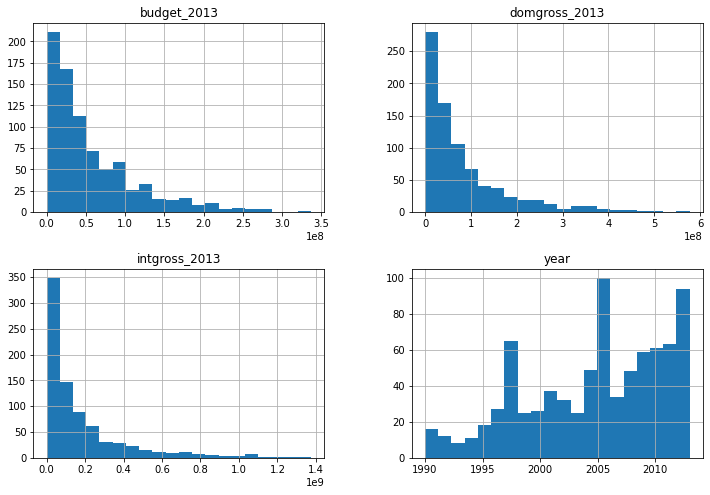

In [9]:
# let's inspect data
hist = df.select(['year','budget_2013', "domgross_2013", "intgross_2013"
                  ]) \
         .sample(False, 0.5, 123) \
         .toPandas() \
         .hist(bins=20,figsize=(12, 8))

### Categorical Features

In [10]:
# Let's inspect string data
df.groupby('clean_test').count().show()
df.groupby('binary').count().show()

+----------+-----+
|clean_test|count|
+----------+-----+
|       men|  167|
|   nowomen|  118|
|        ok|  743|
|   dubious|  123|
|    notalk|  447|
+----------+-----+

+------+-----+
|binary|count|
+------+-----+
|  FAIL|  855|
|  PASS|  743|
+------+-----+



In [11]:
# Applying some transformations: String indexer
from pyspark.ml.feature import StringIndexer

# Indexing 'clean_test'
idx_0 = StringIndexer().setInputCol("clean_test").setOutputCol("clean_test_idx")

# Indexing 'binary'
idx_1 = StringIndexer() \
        .setInputCol("binary") \
        .setOutputCol("binary_idx")

# Applying to df
df = idx_0.fit(df).transform(df)
df = idx_1.fit(df).transform(df)

# Inspect result
df.select(['binary', 'binary_idx','clean_test', 'clean_test_idx']).show()

+------+----------+----------+--------------+
|binary|binary_idx|clean_test|clean_test_idx|
+------+----------+----------+--------------+
|  FAIL|       0.0|    notalk|           1.0|
|  PASS|       1.0|        ok|           0.0|
|  FAIL|       0.0|    notalk|           1.0|
|  FAIL|       0.0|    notalk|           1.0|
|  FAIL|       0.0|       men|           2.0|
|  FAIL|       0.0|       men|           2.0|
|  FAIL|       0.0|    notalk|           1.0|
|  PASS|       1.0|        ok|           0.0|
|  PASS|       1.0|        ok|           0.0|
|  FAIL|       0.0|    notalk|           1.0|
|  PASS|       1.0|        ok|           0.0|
|  PASS|       1.0|        ok|           0.0|
|  PASS|       1.0|        ok|           0.0|
|  PASS|       1.0|        ok|           0.0|
|  FAIL|       0.0|    notalk|           1.0|
|  PASS|       1.0|        ok|           0.0|
|  FAIL|       0.0|   nowomen|           4.0|
|  PASS|       1.0|        ok|           0.0|
|  FAIL|       0.0|   dubious|    

In [12]:
# Step two: One-Hot Encoding
from pyspark.ml.feature import OneHotEncoder

# Encoding 'clean_test'
ohe_0 = OneHotEncoder().setInputCol("clean_test_idx").setOutputCol("clean_test_ohe")

# Encoding 'binary'
ohe_1 = OneHotEncoder().setInputCol("binary_idx").setOutputCol("binary_ohe")

# Let's show what we have
ohe_0.transform(df).select(['clean_test', 'clean_test_idx', 'clean_test_ohe']).show()
ohe_1.transform(df).select(['binary', 'binary_idx', 'binary_ohe']).show()

# Apply ohe_1 to df
df = ohe_1.transform(df)

+----------+--------------+--------------+
|clean_test|clean_test_idx|clean_test_ohe|
+----------+--------------+--------------+
|    notalk|           1.0| (4,[1],[1.0])|
|        ok|           0.0| (4,[0],[1.0])|
|    notalk|           1.0| (4,[1],[1.0])|
|    notalk|           1.0| (4,[1],[1.0])|
|       men|           2.0| (4,[2],[1.0])|
|       men|           2.0| (4,[2],[1.0])|
|    notalk|           1.0| (4,[1],[1.0])|
|        ok|           0.0| (4,[0],[1.0])|
|        ok|           0.0| (4,[0],[1.0])|
|    notalk|           1.0| (4,[1],[1.0])|
|        ok|           0.0| (4,[0],[1.0])|
|        ok|           0.0| (4,[0],[1.0])|
|        ok|           0.0| (4,[0],[1.0])|
|        ok|           0.0| (4,[0],[1.0])|
|    notalk|           1.0| (4,[1],[1.0])|
|        ok|           0.0| (4,[0],[1.0])|
|   nowomen|           4.0|     (4,[],[])|
|        ok|           0.0| (4,[0],[1.0])|
|   dubious|           3.0| (4,[3],[1.0])|
|        ok|           0.0| (4,[0],[1.0])|
+----------

### Assembling Vectors

In [13]:
from pyspark.ml.feature import VectorAssembler

# Assembling a Vector for Logistic Regression
v_0 = VectorAssembler() \
     .setInputCols(["year", "budget_2013", "domgross_2013", "intgross_2013"]) \
     .setOutputCol('features_0')

# Assembling a Vector for Linear Regression
v_1 = VectorAssembler() \
     .setInputCols(["year", "budget_2013", "domgross_2013", "binary_ohe"]) \
     .setOutputCol('features_1')

# Applying
df = v_0.transform(df)
df = v_1.transform(df)

# show
df.select(['features_0', 'features_1']).show()

+--------------------+--------------------+
|          features_0|          features_1|
+--------------------+--------------------+
|[2013.0,1.3E7,2.5...|[2013.0,1.3E7,2.5...|
|[2012.0,4.5658735...|[2012.0,4.5658735...|
|[2013.0,2.0E7,5.3...|[2013.0,2.0E7,5.3...|
|[2013.0,6.1E7,7.5...|[2013.0,6.1E7,7.5...|
|[2013.0,4.0E7,9.5...|[2013.0,4.0E7,9.5...|
|[2013.0,2.25E8,3....|[2013.0,2.25E8,3....|
|[2013.0,9.2E7,6.7...|[2013.0,9.2E7,6.7...|
|[2013.0,1.2E7,1.5...|[2013.0,1.2E7,1.5...|
|[2013.0,1.3E7,1.8...|[2013.0,1.3E7,1.8...|
|[2013.0,1.3E8,6.0...|[2013.0,1.3E8,6.0...|
|[2013.0,4.0E7,1.4...|[2013.0,4.0E7,1.4...|
|[2013.0,2.5E7,3.7...|[2013.0,2.5E7,3.7...|
|[2013.0,5.0E7,1.9...|[2013.0,5.0E7,1.9...|
|[2013.0,1.8E7,3.3...|[2013.0,1.8E7,3.3...|
|[2013.0,5.5E7,1.0...|[2013.0,5.5E7,1.0...|
|[2013.0,3.0E7,3.5...|[2013.0,3.0E7,3.5...|
|[2013.0,7.8E7,1.1...|[2013.0,7.8E7,1.1...|
|[2013.0,7.6E7,3.6...|[2013.0,7.6E7,3.6...|
|[2013.0,5500000.0...|[2013.0,5500000.0...|
|[2013.0,1.2E8,9.3...|[2013.0,1.

### Splitting train and test

In [14]:
# splitting training and test
train, test = df.randomSplit([0.7, 0.3])

## Estimation

### Logistic Regression

In [15]:
from pyspark.ml.classification import LogisticRegression

# instance of Logistic Regression
lr_0 = LogisticRegression(labelCol="binary_idx",featuresCol="features_0")

# let's inspect the parameters
a = lr_0.explainParams().split('\n')
x = 0
for i in a:
    b = i.split(':',1)
    b_0,b_1 = '\033[1m' + b[0] + '\033[0m', b[1]
    print("""{}. {} : {}
    """.format(x, b_0,b_1), flush=True)
    x=x+1

0. aggregationDepth :  suggested depth for treeAggregate (>= 2). (default: 2)
    
1. elasticNetParam :  the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
    
2. family :  The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
    
3. featuresCol :  features column name. (default: features, current: features_0)
    
4. fitIntercept :  whether to fit an intercept term. (default: True)
    
5. labelCol :  label column name. (default: label, current: binary_idx)
    
6. lowerBoundsOnCoefficients :  The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
    
7. lowerBoundsOnIntercepts :  T

In [16]:
# let's fit data
fitLr_0 = lr_0.fit(train)

# Print the coefficients and intercept
print(""" 

Coefficients:
============
{}


Intercept:
=========
{}

""".format(fitLr_0.coefficients, fitLr_0.intercept), flush=True)

# comparing binary and prediction
fitLr_0.transform(train).select("binary_idx", "prediction").show()

 

Coefficients:
[0.00019115001461326143,-7.923009910075992e-09,5.14759242851688e-10,1.349420869412762e-10]


Intercept:
-0.19831807350173747


+----------+----------+
|binary_idx|prediction|
+----------+----------+
|       1.0|       1.0|
|       0.0|       0.0|
|       0.0|       1.0|
|       0.0|       1.0|
|       0.0|       0.0|
|       0.0|       1.0|
|       1.0|       1.0|
|       1.0|       1.0|
|       0.0|       0.0|
|       1.0|       1.0|
|       1.0|       0.0|
|       0.0|       0.0|
|       0.0|       0.0|
|       0.0|       0.0|
|       0.0|       0.0|
|       1.0|       1.0|
|       1.0|       1.0|
|       0.0|       0.0|
|       0.0|       0.0|
|       0.0|       0.0|
+----------+----------+
only showing top 20 rows



In [17]:
# get some more info
s_0 = fitLr_0.summary

# Obtain the objective per iteration
objectiveHistory = s_0.objectiveHistory

print("""
- Accuracy: {}
- Area Under ROC : {}
- False Positive Rate by Label: {}
- Precision by Label: {}
- Tot. Iterations: {}
- Objective History: 
{}
""".format(s_0.accuracy, s_0.areaUnderROC,
           s_0.falsePositiveRateByLabel, s_0.precisionByLabel,
           s_0.totalIterations, [obj for obj in objectiveHistory]),
      flush=True)


- Accuracy: 0.581945661700263
- Area Under ROC : 0.6152811811780763
- False Positive Rate by Label: [0.5184466019417475, 0.3354632587859425]
- Precision by Label: [0.6090775988286969, 0.5414847161572053]
- Tot. Iterations: 51
- Objective History: 
[0.6884076889063466, 0.6883181071176948, 0.6854656458372611, 0.6762411521768334, 0.6761759540915232, 0.6761720393324852, 0.6761699625982208, 0.6761569310173708, 0.6761303803630724, 0.6760545485525062, 0.6758697407926855, 0.6754177887524073, 0.6744541651873972, 0.6744179980499442, 0.6728313447504553, 0.671315584752617, 0.6707420029762586, 0.6706377482695226, 0.6706328338634925, 0.6706327990995035, 0.6706327975325345, 0.6706327972967637, 0.6706327944421704, 0.6706327886141348, 0.6706327718442211, 0.6706327322761929, 0.670632723155634, 0.6706326218152636, 0.6706323067775121, 0.6706317396452673, 0.6706309153603977, 0.670630328941791, 0.670630163103641, 0.6706301485773097, 0.670630148144775, 0.6706301479964797, 0.6706301475590855, 0.6706301475565

### Linear Regression

In [18]:
from pyspark.ml.regression import LinearRegression

# instance of Linear Regression
lr_1 = LinearRegression(labelCol="intgross_2013",featuresCol="features_1")

# let's inspect parameters
a = lr_1.explainParams().split('\n')
x = 0
for i in a:
    b = i.split(':',1)
    b_0,b_1 = '\033[1m' + b[0] + '\033[0m', b[1]
    print("""{}. {} : {}
    """.format(x, b_0,b_1), flush=True)
    x=x+1

# fit
fitLr_1 = lr_1.fit(df)

0. aggregationDepth :  suggested depth for treeAggregate (>= 2). (default: 2)
    
1. elasticNetParam :  the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
    
2. epsilon :  The shape parameter to control the amount of robustness. Must be > 1.0. Only valid when loss is huber (default: 1.35)
    
3. featuresCol :  features column name. (default: features, current: features_1)
    
4. fitIntercept :  whether to fit an intercept term. (default: True)
    
5. labelCol :  label column name. (default: label, current: intgross_2013)
    
6. loss :  The loss function to be optimized. Supported options: squaredError, huber. (default: squaredError)
    
7. maxIter :  max number of iterations (>= 0). (default: 100)
    
8. predictionCol :  prediction column name. (default: prediction)
    
9. regParam :  regularization parameter (>= 0). (default: 0.0)
    
10. solver :  The solver algorithm for optimiz

In [19]:
# summary stats
s_1 = fitLr_1.summary
print("""
- R^2 adj: {}
- RMSE : {}
- Intercept: {}
- Coefficients: {}
- p-values: {}
""".format(s_1.r2adj, s_1.rootMeanSquaredError, fitLr_1.intercept, fitLr_1.coefficients, s_1.pValues),
      flush=True)


- R^2 adj: 0.9131851999795355
- RMSE : 69818762.76650697
- Intercept: -4599900747.5218725
- Coefficients: [2279181.5468098656,0.6205229945580747,2.164565679609964,-2572331.9857173893]
- p-values: [1.0369483049998962e-13, 0.0, 0.0, 0.4702870069042637, 7.194245199571014e-14]



In [20]:
# let's create a reference dataframe
results = fitLr_1.transform(train).select(['intgross_2013', 'prediction'])
results.createOrReplaceTempView('results')
spark_session.sql(
    "SELECT format_number(intgross_2013,2) as intgross, format_number(prediction,2) as prediction FROM results"
).show()

+--------------+----------------+
|      intgross|      prediction|
+--------------+----------------+
| 60,918,157.00|   53,888,061.47|
|427,582,507.00|  463,340,549.51|
|922,868,068.00|  797,357,656.76|
|849,917,050.00|1,052,551,471.69|
|357,486,568.00|  432,153,233.19|
|  7,796,169.00|  -42,281,840.74|
|  8,946,919.00|  -37,218,634.80|
|771,396,947.00|  639,695,139.31|
|354,127,435.00|  298,627,063.93|
| 29,717,001.00|   11,058,703.44|
|327,629,772.00|  390,122,692.59|
| 64,220,970.00|   95,620,203.31|
|514,714,575.00|  452,799,377.33|
|148,724,056.00|  281,717,530.39|
|668,083,163.00|  601,319,568.21|
|471,724,395.00|  443,292,646.46|
|  2,100,070.00|  -57,480,131.42|
|884,189,932.00|  800,180,040.39|
|263,165,037.00|  191,726,616.69|
|443,020,974.00|  605,292,043.94|
+--------------+----------------+
only showing top 20 rows



## Save Data

In [21]:
# save to Postgre
results.write \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://localhost:5433/smm695") \
    .option("dbtable", "results") \
    .option("user", "postgres") \
    .option("password", "smm695") \
    .option("driver", "org.postgresql.Driver") \
    .mode("overwrite") \
    .save()

In [22]:
# save to MongoDB
results.write \
        .option("spark.mongodb.output.uri", "mongodb://127.0.0.1/pyspark.results") \
        .format("mongo") \
        .mode("overwrite") \
        .save()

# Pipeline

In [23]:
from pyspark.ml.feature import RFormula
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import TrainValidationSplit

In [24]:
# R Formula to perform simple preprocessing
rf = RFormula()

# logistic regression
lr = LogisticRegression().setLabelCol("binary_idx").setFeaturesCol("features")

# let's create a pipeline
pipeline = Pipeline().setStages([rf, lr])

# setting some parameters
params = ParamGridBuilder()\
         .addGrid(rf.formula, 
                  ["binary_idx ~ budget_2013",
                   "binary_idx ~ year + budget_2013", 
                   "binary_idx ~ year + budget_2013 + domgross_2013 + intgross_2013"]) \
         .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
         .addGrid(lr.regParam, [0.0, 0.01, 0.1]) \
         .build()

# evaluation
evaluator = BinaryClassificationEvaluator() \
            .setMetricName("areaUnderROC") \
            .setRawPredictionCol("prediction") \
            .setLabelCol("label")

# hyperparameter tuning
tvs = TrainValidationSplit() \
      .setTrainRatio(0.75) \
      .setEstimatorParamMaps(params) \
      .setEstimator(pipeline) \
      .setEvaluator(evaluator)

In [25]:
# fit 
tvsFitted = tvs.fit(train)

In [26]:
# get info
l = []
x = 0
for i in tvsFitted.getEstimatorParamMaps():
    for a in i.keys():
        l.append(a)
    b, c, d = i.get(l[0]), i.get(l[1]), i.get(l[2])
    print("""
    {}. \033[1mModel\033[0m: {} \033[1mElasticNet\033[0m: {} \033[1mRegular.\033[0m: {}""".format(x, b, c, d))
    x = x+1


    0. Model: binary_idx ~ budget_2013 ElasticNet: 0.0 Regular.: 0.0

    1. Model: binary_idx ~ budget_2013 ElasticNet: 0.0 Regular.: 0.01

    2. Model: binary_idx ~ budget_2013 ElasticNet: 0.0 Regular.: 0.1

    3. Model: binary_idx ~ budget_2013 ElasticNet: 0.5 Regular.: 0.0

    4. Model: binary_idx ~ budget_2013 ElasticNet: 0.5 Regular.: 0.01

    5. Model: binary_idx ~ budget_2013 ElasticNet: 0.5 Regular.: 0.1

    6. Model: binary_idx ~ budget_2013 ElasticNet: 1.0 Regular.: 0.0

    7. Model: binary_idx ~ budget_2013 ElasticNet: 1.0 Regular.: 0.01

    8. Model: binary_idx ~ budget_2013 ElasticNet: 1.0 Regular.: 0.1

    9. Model: binary_idx ~ year + budget_2013 ElasticNet: 0.0 Regular.: 0.0

    10. Model: binary_idx ~ year + budget_2013 ElasticNet: 0.0 Regular.: 0.01

    11. Model: binary_idx ~ year + budget_2013 ElasticNet: 0.0 Regular.: 0.1

    12. Model: binary_idx ~ year + budget_2013 ElasticNet: 0.5 Regular.: 0.0

    13. Model: binary_idx ~ year + budget_2013 Elastic

In [27]:
# best model info
bs_0 = tvsFitted.bestModel.stages[0].extractParamMap()
bs_1 = tvsFitted.bestModel.stages[1].extractParamMap()

l = []
m = []
for i in bs_0.keys():
    l.append(i)
for i in bs_1.keys():
    m.append(i)
        
print("""
Model: {} 

ElasticNet: {} 

Regularization: {}
""".format(bs_0.get(l[-1]), bs_1.get(m[1]), bs_1.get(m[-4])), flush=True)


Model: binary_idx ~ year + budget_2013 

ElasticNet: 0.0 

Regularization: 0.01



In [28]:
# Best Model
s = tvsFitted.bestModel.stages[1].summary

# Obtain the objective per iteration
objectiveHistory = s.objectiveHistory

print("""
- Accuracy: {}
- Area Under ROC : {}
- False Positive Rate by Label: {}
- Precision by Label: {}
- Tot. Iterations: {}
- Objective History: 
{}
""".format(s.accuracy, s.areaUnderROC,
           s.falsePositiveRateByLabel, s.precisionByLabel,
           s.totalIterations, [obj for obj in objectiveHistory]),
      flush=True)


- Accuracy: 0.5880806310254163
- Area Under ROC : 0.6139613511585351
- False Positive Rate by Label: [0.5262135922330097, 0.31789137380191695]
- Precision by Label: [0.6117478510028653, 0.5507900677200903]
- Tot. Iterations: 30
- Objective History: 
[0.6884076889063466, 0.6883791958231267, 0.6883088709137742, 0.6875600473588818, 0.6862629715196343, 0.6830786839554474, 0.6781909831161429, 0.6734790670923877, 0.6720093180020734, 0.6718307816357401, 0.67181543717442, 0.6718151860030718, 0.6718151843301744, 0.6718151843290201, 0.6718151843289951, 0.671815184328695, 0.6718151843280836, 0.6718151843263043, 0.6718151843218295, 0.6718151843099376, 0.6718151842789885, 0.6718151841977588, 0.6718151839852873, 0.6718151834289636, 0.6718151819734663, 0.6718151781661752, 0.671815168216109, 0.6718151422370657, 0.6718150744705004, 0.671814897913341]



In [29]:
# let's see how it performs on the test
evaluator.evaluate(tvsFitted.transform(test))

0.5314295564238106

# References

* Bill Chambers, Matei Zaharia 2018,["Spark: The Definitive Guide"](https://www.oreilly.com/library/view/spark-the-definitive/9781491912201/) <img src="images/_3.png" width="20%">
* [FiveThirtyEight](https://github.com/fivethirtyeight), 2014
[<img src="images/_2.png" width="40%">](https://fivethirtyeight.com/features/the-dollar-and-cents-case-against-hollywoods-exclusion-of-women/)